## import packages

In [57]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import pyls # PLS: behavioral and mean-centered
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis

import pathlib

###################### update path!! #####################################
base_path = '/root_dir/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

## define variables (please check!)

In [58]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'
MNI_2mm_brain = derivatives_dir + '/MNI152_T1_2mm_brain.nii.gz'

sns.set_style("whitegrid")

coords=(-15, 0, 15, 30, 45, 60, 75, 90)

## run qBOLD toolbox
%run qBOLD_fun.ipynb

sns.set_style("whitegrid")
fontsize=20
plt.rcParams['legend.title_fontsize'] = 'x-large'

In [70]:
## Please which CMRO2 version to use ##
###################################################

#CMRO2_mode = 'orig' ## orig = CMRO2 maps NOT corrected for CBV changes, only CMRO2 maps of subj > 55 in CALC condition are corrected for CBV increases
CMRO2_mode = 'corrected' ## CMRO2 CALC maps corrected for CBV changes (but MEM maps are not corrected)

## Please specify task & baseline ##
####################################

#baseline='rest'
baseline='control'
#task='calc'
task='mem'

conds = [baseline, task]
contrast=task+baseline

## Please specify subject list##
################################

if baseline == 'control' and task == 'calc':
    #N=40
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
else: #N=30, without p053
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]


##########################################################
## please select which group task mask to apply!! ##
##########################################################

#masks = ['Yeo', 'PLS BOLD', 'PLS CBF', 'GLM BOLD']
#masks = ['PLS CBF', 'PLS CMRO2', 'PLS OEF']
mask = [ 'PLS BOLD'] ## this is the PLS BOLD group mask
#masks = [ 'PLS CBF']
#masks = ['GLM_BOLD']


### other variables ##############
##################################

N_subj = str(len(sids))
GM_thresh = 0.5
BSR_thr=2

## Gray-matter mask, excluding areas with low signal-to-noise ratio according to fMRI data

YEO_SNR_mask = os.path.join( derivatives_dir, 'task-all_space-MNI152_res-2_SNR_YEO_group_mask.nii.gz')
mask_img = nib.load(YEO_SNR_mask)
masker_GM = input_data.NiftiMasker(mask_img=YEO_SNR_mask) ## exclude areas with too less SNR (based on the localizer data)
YEO_SNR_mask_arr = np.array(mask_img.dataobj)

### Blue-red color palette

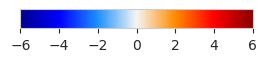

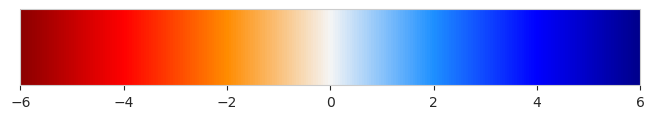

In [71]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

colors = ["darkblue", "blue", "dodgerblue",  "whitesmoke","darkorange", "red", "darkred"]
BlueRed = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(3,0.5))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed), 
             cax=ax, ticks=bounds, orientation='horizontal')

## inverted colormap: BlueRed_r
colors = [ "darkred","red", "darkorange", "whitesmoke", "dodgerblue", "blue","darkblue"]
BlueRed_r = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(8, 2))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed_r), 
             cax=ax, ticks=bounds, orientation='horizontal')

In [72]:
if mask[0] == 'PLS BOLD':
    PLS_BOLD = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'.nii.gz'
    PLS_BOLD_mask = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_bin.nii.gz'
    ! fslmaths {PLS_BOLD} -abs -bin {PLS_BOLD_mask}
    masker = input_data.NiftiMasker(mask_img = PLS_BOLD_mask)
    mask_arr = np.array(nib.load(PLS_BOLD_mask).dataobj)
    mask_len = len (mask_arr[abs(mask_arr)>0])
    
    
BOLD_percchange = np.zeros((len(sids), mask_len))
CBF_percchange = np.zeros((len(sids), mask_len))
CMRO2_percchange = np.zeros((len(sids), mask_len))

## SNR-GM mask (same mask was used for the PLS input)
SNR_GM_BOLD_mask_arr = np.array(nib.load(YEO_SNR_mask).dataobj)
SNR_GM_mask_len = len (SNR_GM_BOLD_mask_arr[abs(SNR_GM_BOLD_mask_arr)>0])
BOLD_percchange_GM = np.zeros((len(sids), SNR_GM_mask_len))
CBF_percchange_GM = np.zeros((len(sids), SNR_GM_mask_len))
CMRO2_percchange_GM = np.zeros((len(sids), SNR_GM_mask_len))

for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)

    sub_dir = os.path.join(data_dir, sub)

    dir_anat = os.path.join(sub_dir, 'anat')
    dir_func = os.path.join(sub_dir, 'func')
    dir_perf = os.path.join(sub_dir, 'perf')

    dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
    dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
    dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
    dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

    #load percent signal change image
    BOLD_percchange_nii = nib.load(dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_desc-fmriprep_BOLD_percchange.nii.gz')
    BOLD_percchange[i, :] = masker.fit_transform(BOLD_percchange_nii) 
    BOLD_percchange_GM[i, :] = masker_GM.fit_transform(BOLD_percchange_nii) 
    
    ## for CBF, create %change
    CBF_task = masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + task + '_space-MNI152_cbf.nii.gz'))/0.75
    CBF_baseline = masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_cbf.nii.gz'))/0.75
    CBF_percchange[i, :]  = (CBF_task - CBF_baseline) / CBF_baseline *100
    
    CBF_baseline_GM = masker_GM.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_cbf.nii.gz'))/0.75
    CBF_task_GM = masker_GM.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + task + '_space-MNI152_cbf.nii.gz'))/0.75
    CBF_percchange_GM[i, :]  = (CBF_task_GM - CBF_baseline_GM) / CBF_baseline_GM *100
    
    ## for CMR02, create %change
    CMRO2_baseline = masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + baseline + '_space-MNI152_desc-orig_cmro2.nii.gz'))
    if CMRO2_mode == 'orig' or task !='calc': ## without CBV correction
            CMRO2_task = masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant_cmro2.nii.gz'))
    if CMRO2_mode == 'corrected' and task == 'calc':  
            CMRO2_task = masker.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant-corrected_cmro2.nii.gz'))

    
    CMRO2_percchange[i, :]  = (CMRO2_task- CMRO2_baseline) / CMRO2_baseline *100 

    CMRO2_baseline_GM = masker_GM.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-' + baseline +  '_space-MNI152_desc-orig_cmro2.nii.gz'))
    if CMRO2_mode == 'orig' or task !='calc': ## without CBV correction
            CMRO2_task_GM = masker_GM.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant_cmro2.nii.gz'))
    if CMRO2_mode == 'corrected' and task == 'calc':  
            CMRO2_task_GM = masker_GM.fit_transform(os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant-corrected_cmro2.nii.gz'))
                                      
                                                                                      
    CMRO2_percchange_GM[i, :]  = (CMRO2_task_GM - CMRO2_baseline_GM) / CMRO2_baseline_GM *100       

## * 100 to get % values and not ratios
BOLD_percchange_median = np.median(BOLD_percchange, axis=0)
CBF_percchange_median = np.median(CBF_percchange, axis=0)
CMRO2_percchange_median = np.median(CMRO2_percchange, axis=0)

BOLD_percchange_median_GM = np.median(BOLD_percchange_GM, axis=0)
CBF_percchange_median_GM = np.median(CBF_percchange_GM, axis=0)
CMRO2_percchange_median_GM = np.median(CMRO2_percchange_GM, axis=0)



sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055


### plot all positive & negative voxels in one scatterplot

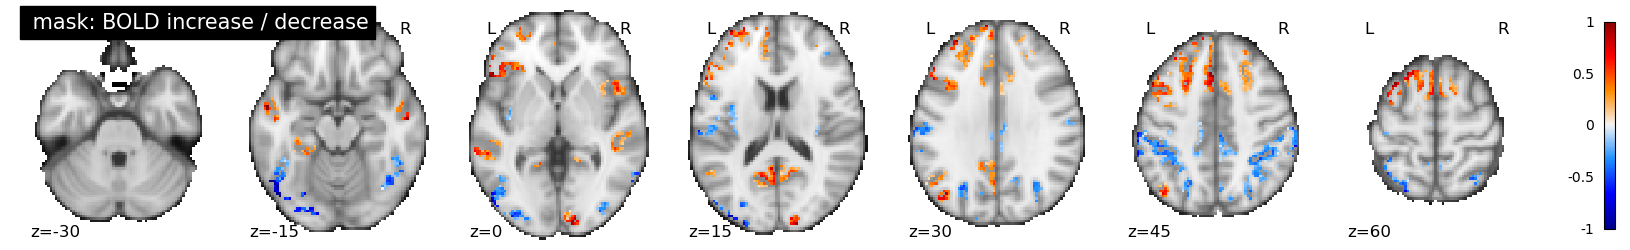

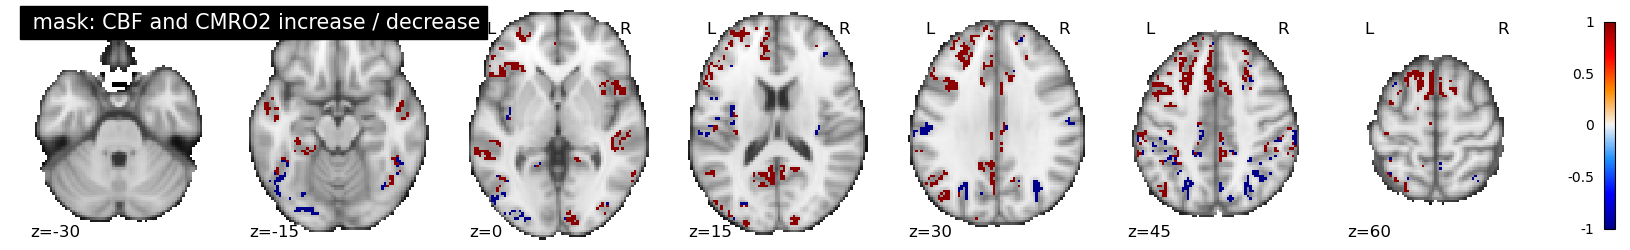

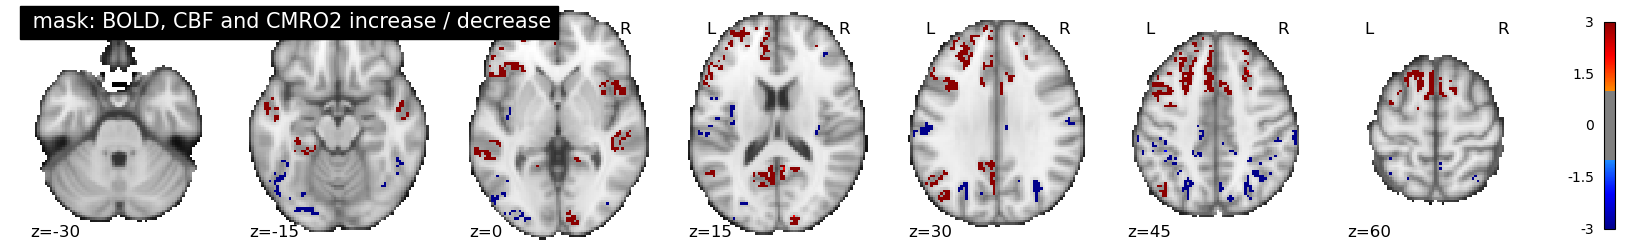

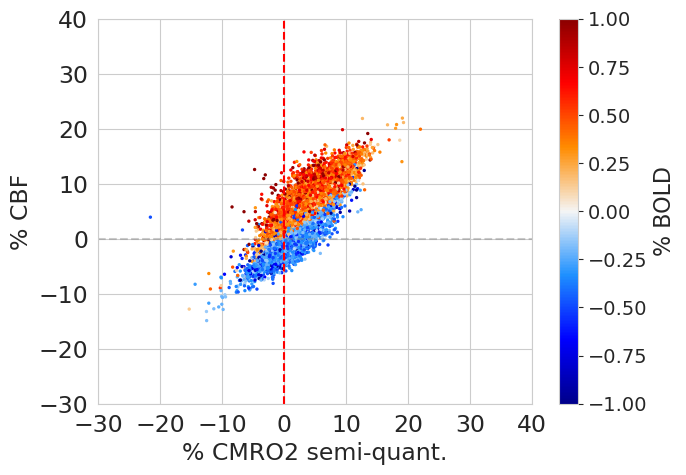

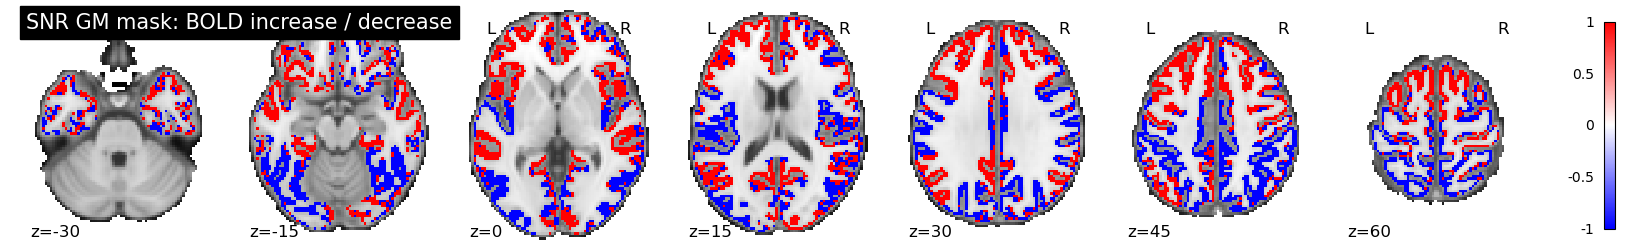

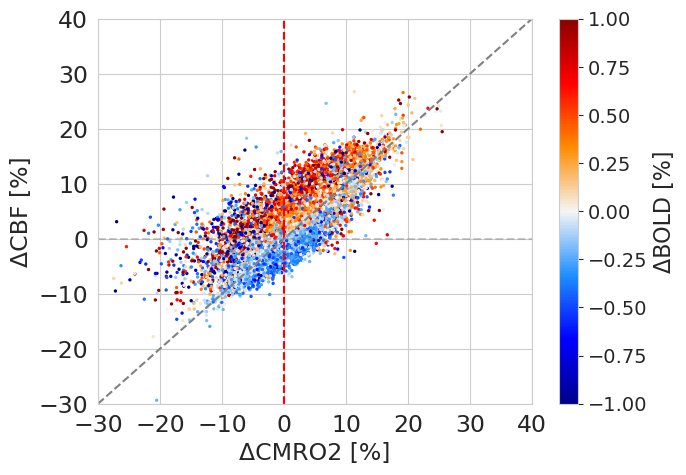

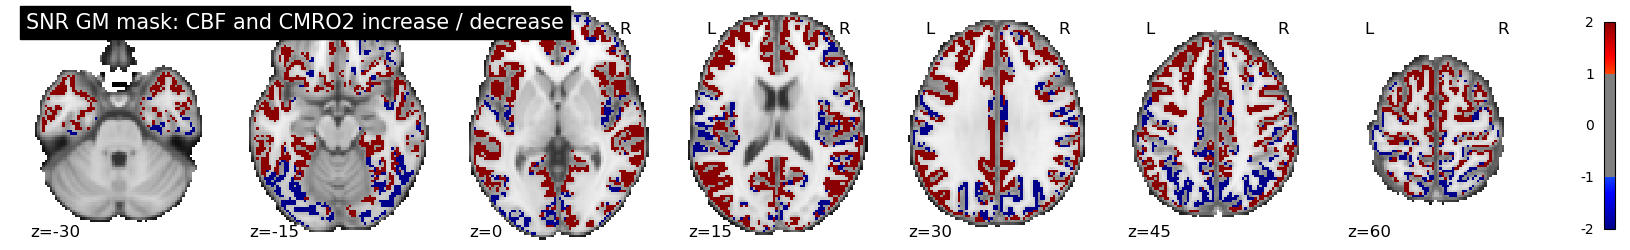

In [73]:
from matplotlib.colors import ListedColormap

colors_lightorange = ListedColormap(["navajowhite"])
colors_lightblue = ListedColormap(["lightskyblue"])

coords = (-30, -15, 0, 15, 30, 45, 60)
#DMN = os.path.join(tmp_dir,'Yeo2011_17Networks_MNI152_FreeSurferConformed2mm_MNI_DMN.nii.gz')
colors=BlueRed


BOLD_nifti = masker.inverse_transform(BOLD_percchange_median)
plot=plotting.plot_img(BOLD_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=colors, colorbar=True,
                cut_coords = coords,  title=   ' mask: BOLD increase / decrease',vmin=-1, vmax=1 )
plot=plotting.plot_img(BOLD_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=colors, colorbar=True,
                cut_coords = coords,  title=  ' mask: BOLD',vmin=-1, vmax=1,
                output_file=results_dir + '/BOLD_' + contrast +  '.pdf')

## plot %signal change in CMRO2 and CBF vs. BOLD (in color) ##
##############################################################

## group mask ##
###################

## plot in brain
overlap_CMRO2_CBF = np.zeros((3, len(CMRO2_percchange_median)))
overlap_CMRO2_CBF[0, CMRO2_percchange_median>0.01] = 1
overlap_CMRO2_CBF[0, CMRO2_percchange_median<-0.01] = -1
overlap_CMRO2_CBF[1, CBF_percchange_median>0.01] = 1
overlap_CMRO2_CBF[1, CBF_percchange_median<-0.01] = -1
overlap_CMRO2_CBF_sum = np.sum(overlap_CMRO2_CBF, axis=0)

CBF_CMRO2_nifti = masker.inverse_transform(overlap_CMRO2_CBF_sum)
plot=plotting.plot_img(CBF_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=colors, colorbar=True,
                cut_coords = coords,  title=  ' mask: CBF and CMRO2 increase / decrease', vmin=-1, vmax=1)
#plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)

##plot with BOLD
overlap_CMRO2_CBF[2, BOLD_percchange_median>0.001] = 1
overlap_CMRO2_CBF[2, BOLD_percchange_median<-0.001] = -1
overlap_CMRO2_CBF_sum = np.sum(overlap_CMRO2_CBF, axis=0)
CBF_CMRO2_nifti = masker.inverse_transform(overlap_CMRO2_CBF_sum)
plot=plotting.plot_img(CBF_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 1, display_mode='z', cmap=colors, colorbar=True,
                cut_coords = coords,  title=  ' mask: BOLD, CBF and CMRO2 increase / decrease')
#plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)


### get regression equation and plot line
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(CMRO2_percchange_median, CBF_percchange_median, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(-30, 40, num=200)

## plot %signal change in CMRO2 and CBF vs. BOLD (in color)
fig, ax = plt.subplots(1, 1, figsize=(7,5))
scatter = ax.scatter(CMRO2_percchange_median, CBF_percchange_median, c=BOLD_percchange_median, s=2, cmap = colors, vmin=-1, vmax=1)

cbar = plt.colorbar(scatter)
cbar.set_label("% BOLD", fontsize=16)
cbar.ax.tick_params(labelsize=14)
# Plot regression line
#ax.plot(xseq, a + b * xseq, color="grey", lw=2.5, linestyle='dashed');
#ax.text(20, 40, 'b=' + str(round(b, 2)), fontsize=fontsize)
    

plt.hlines(0, -30, 40, color='grey', alpha=0.4, linestyles='dashed')
plt.vlines(0, -30, 40, color='red',alpha=1, linestyles='dashed')

ax.set_xlabel('% CMRO2 semi-quant.', fontsize=fontsize)
ax.set_ylabel('% CBF', fontsize=fontsize)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)
    
ax.set_xlim(-30,40)
ax.set_ylim(-30,40)

fig.savefig(results_dir + '/CMRO2_CBF'+ '_mask_' +  contrast +  '_'+CMRO2_mode +'.png', dpi=300, bbox_inches='tight')

plt.show()


## GM SNR mask ##
#################

## plot only BOLD
BOLD = np.zeros((1, len(BOLD_percchange_median_GM)))
BOLD[0, BOLD_percchange_median_GM>0.001] = 1
BOLD[0, BOLD_percchange_median_GM<-0.001] = -1
BOLD_sum = np.sum(BOLD, axis=0)

BOLD_nifti = masker_GM.inverse_transform(BOLD_sum)

plot=plotting.plot_img(BOLD_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='bwr', colorbar=True,
                cut_coords = coords,  title= 'SNR GM mask: BOLD increase / decrease')
#plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)

### get regression equation and plot line
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
#b, a = np.polyfit(CMRO2_percchange_median_GM, CBF_percchange_median_GM, deg=1)

# Create sequence of 100 numbers from 0 to 100 
#xseq = np.linspace(-30, 40, num=200)

## plot %signal change in CMRO2 and CBF vs. BOLD (in color)
fig, ax = plt.subplots(1, 1, figsize=(7,5))
scatter = ax.scatter(CMRO2_percchange_median_GM, CBF_percchange_median_GM, c=BOLD_percchange_median_GM, s=2, cmap = colors, vmin=-1, vmax=1)
# Plot regression line
#ax.plot(xseq, a + b * xseq, color="grey", lw=2.5, linestyle='dashed');
#ax.text(20, 40, 'b=' + str(round(b, 2)), fontsize=fontsize)

cbar = plt.colorbar(scatter)
cbar.set_label("ΔBOLD [%]", fontsize=16)
cbar.ax.tick_params(labelsize=14)

#ax.set_title("change in BOLD, median across subjects, SNR GM mask")

plt.hlines(0, -30, 40, color='grey', alpha=0.4, linestyles='dashed')
plt.vlines(0, -30, 40, color='red',alpha=1, linestyles='dashed')

ax.set_xlabel('ΔCMRO2 [%]', fontsize=fontsize)
ax.set_ylabel('ΔCBF [%]', fontsize=fontsize)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)
ax.plot([-30, 40], [-30, 40], color='gray', linestyle='--')


ax.set_xlim(-30,40)
ax.set_ylim(-30,40)

fig.savefig(results_dir + '/CMRO2_CBF'+ '_mask_' + contrast +  '_'+CMRO2_mode +'_GM.png', dpi=300, bbox_inches='tight')

plt.show()

## plot in brain
overlap_CMRO2_CBF = np.zeros((3, len(CMRO2_percchange_median_GM)))
overlap_CMRO2_CBF[0, CMRO2_percchange_median_GM>0.01] = 1
overlap_CMRO2_CBF[0, CMRO2_percchange_median_GM<-0.01] = -1
overlap_CMRO2_CBF[1, CBF_percchange_median_GM>0.01] = 1
overlap_CMRO2_CBF[1, CBF_percchange_median_GM<-0.01] = -1
overlap_CMRO2_CBF_sum = np.sum(overlap_CMRO2_CBF, axis=0)

CBF_CMRO2_nifti = masker_GM.inverse_transform(overlap_CMRO2_CBF_sum)
plot=plotting.plot_img(CBF_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 1, display_mode='z', cmap=colors, colorbar=True,
                cut_coords = coords,  title= 'SNR GM mask: CBF and CMRO2 increase / decrease')
#plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)


## plot concordant & discordant voxels, separately for positive and negative BOLD

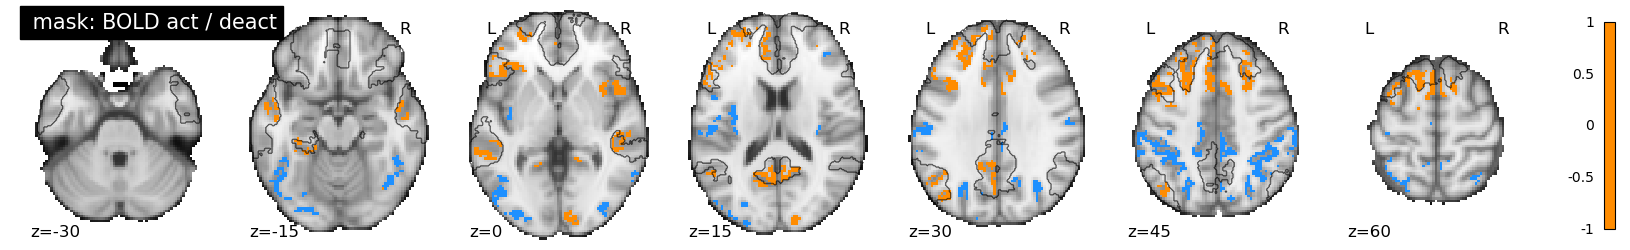

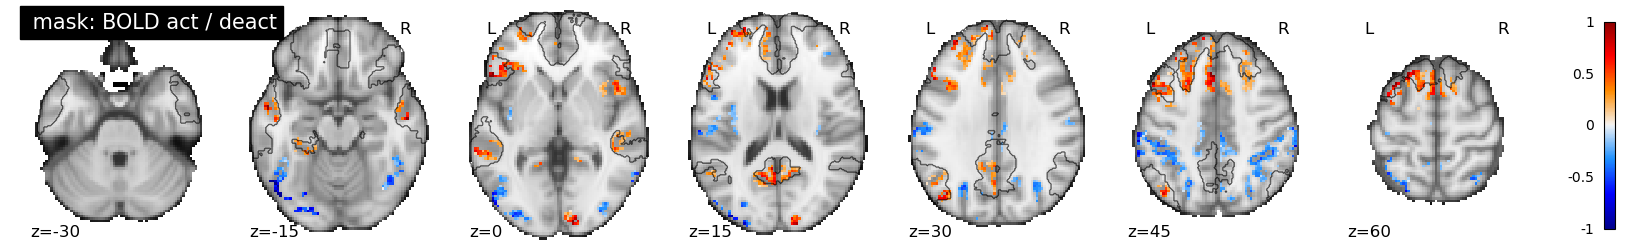

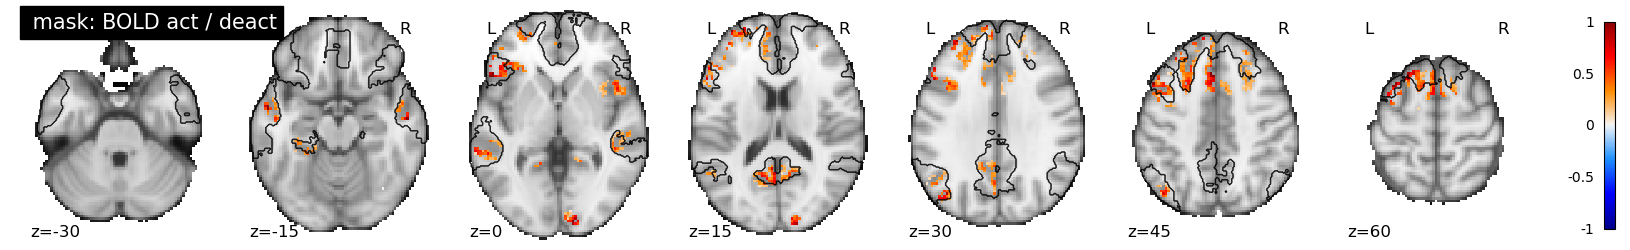

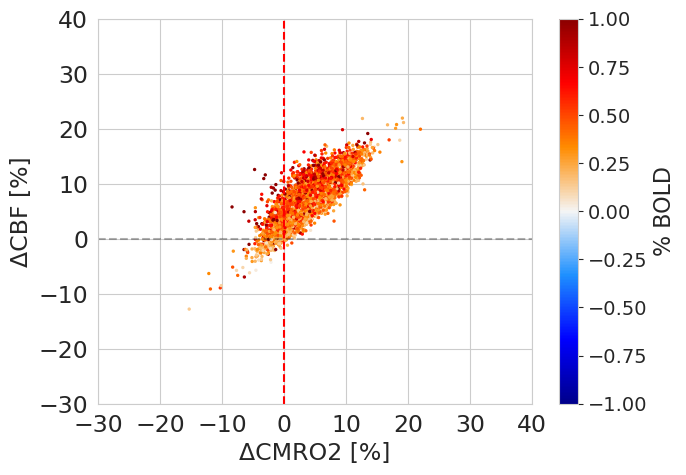

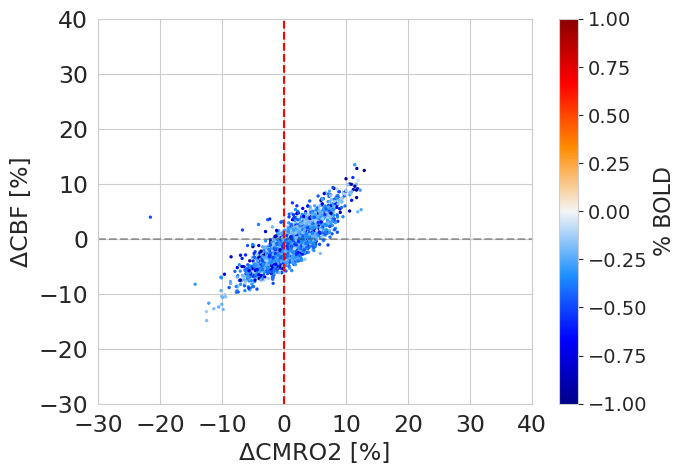

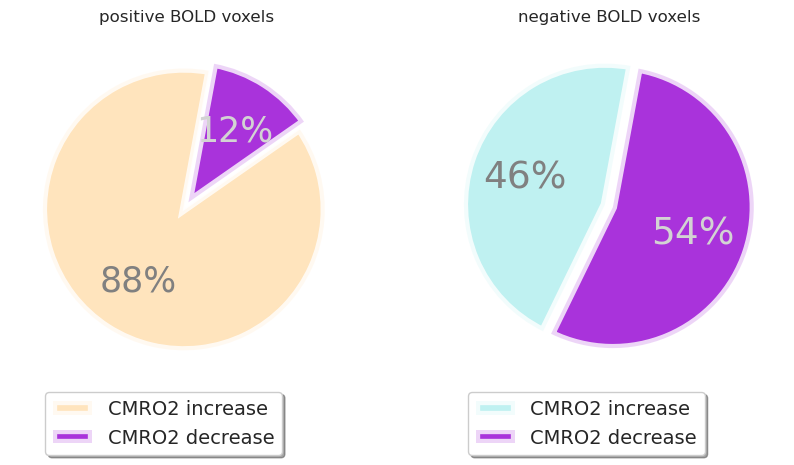

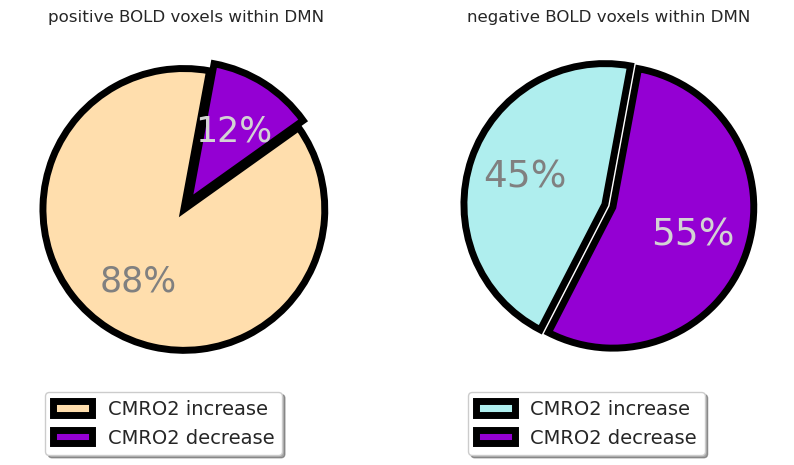

number of negative BOLD voxels within DMN: 2600
number of positive BOLD voxels within DMN: 5178


In [74]:
sns.set_style("whitegrid")
## only look at fully quant CMRO2 and within BOLD PLS region 

coords = (-30, -15, 0, 15, 30, 45, 60)
DMN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_DMN.nii.gz')
colors = BlueRed
colors_bin = ListedColormap(["dodgerblue", "darkorange"])
colors_lightorange = ListedColormap(["navajowhite"])
colors_lightblue = ListedColormap(["paleturquoise"])

## plot only BOLD
BOLD = np.zeros((1, len(BOLD_percchange_median)))
BOLD[0, BOLD_percchange_median>0.001] = 1
BOLD[0, BOLD_percchange_median<-0.001] = -1
BOLD_sum = np.sum(BOLD, axis=0)

BOLD_nifti_bin = masker.inverse_transform(BOLD_sum)
BOLD_nifti = masker.inverse_transform(BOLD_percchange_median)
BOLD_percchange_pos = np.zeros(BOLD_percchange_median.shape)
BOLD_percchange_pos[BOLD_percchange_median>0]=BOLD_percchange_median[BOLD_percchange_median>0]
BOLD_nifti_pos = masker.inverse_transform(BOLD_percchange_pos)

plot=plotting.plot_img(BOLD_nifti_bin, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=colors_bin, colorbar=True,
                cut_coords = coords,  title=   ' mask: BOLD act / deact')
plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.1)
plot=plotting.plot_img(BOLD_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=colors, vmin=-1, vmax=1, colorbar=True,
                cut_coords = coords,  title=   ' mask: BOLD act / deact')
plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.1)

##only positive 
plot=plotting.plot_img(BOLD_nifti_pos, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=colors, vmin=-1, vmax=1, colorbar=True,
                cut_coords = coords,  title=   ' mask: BOLD act / deact')
#plot.add_contours(PLS_BOLD_intersect_mask,  colors='mediumseagreen', alpha = 1, linewidths=0.2)
plot.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.2)

##############################################################
fontsize=17 
plt.rcParams['legend.title_fontsize'] = 'x-large'


## group mask ##
###################

## only positive BOLD voxels ##
###############################

BOLD_percchange_median_pos = np.delete(BOLD_percchange_median, np.where(BOLD_percchange_median<=0))
CMRO2_percchange_median_pos = np.delete(CMRO2_percchange_median, np.where(BOLD_percchange_median<=0)) 
CBF_percchange_median_pos = np.delete(CBF_percchange_median, np.where(BOLD_percchange_median<=0)) 

### get regression equation and plot line
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)

b, a = np.polyfit(CMRO2_percchange_median_pos, CBF_percchange_median_pos, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(-40, 40, num=200)


## plot %signal change in CMRO2 and CBF vs. BOLD (in color)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

scatter = ax.scatter(CMRO2_percchange_median_pos, CBF_percchange_median_pos, c=BOLD_percchange_median_pos, s=2, cmap =colors, vmin=-1, vmax=1)
# Plot regression line
#ax.plot(xseq, a + b * xseq, color="grey", lw=2.5, linestyle='dashed');
#ax.text(20, 40, 'b=' + str(round(b, 2)), fontsize=fontsize)

cbar = plt.colorbar(scatter)
cbar.set_label("% BOLD", fontsize=16)
cbar.ax.tick_params(labelsize=14)
    
plt.hlines(0, -30, 40, color='black', alpha=0.3, linestyles='dashed')
plt.vlines(0, -30, 40, color='red',alpha=1, linestyles='dashed')

ax.set_xlabel('ΔCMRO2 [%]', fontsize=fontsize)
ax.set_ylabel('ΔCBF [%]', fontsize=fontsize)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)
    
ax.set_xlim(-30,40)
ax.set_ylim(-30,40)
fig.savefig(results_dir + '/CMRO2_CBF'+ '_mask_'  + contrast +  '_pos.png', dpi=300, bbox_inches='tight')

plt.show()


## only negative BOLD voxels ##
###############################
BOLD_percchange_median_neg = np.delete(BOLD_percchange_median, np.where(BOLD_percchange_median>=0))
CMRO2_percchange_median_neg = np.delete(CMRO2_percchange_median, np.where(BOLD_percchange_median>=0)) 
CBF_percchange_median_neg = np.delete(CBF_percchange_median, np.where(BOLD_percchange_median>=0)) 

### get regression equation and plot line
# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(CMRO2_percchange_median_neg, CBF_percchange_median_neg, deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(-40, 40, num=200)

## plot %signal change in CMRO2 and CBF vs. BOLD (in color)
fig, ax = plt.subplots(1, 1, figsize=(7,5))
scatter = ax.scatter(CMRO2_percchange_median_neg, CBF_percchange_median_neg, c=BOLD_percchange_median_neg, s=2, cmap =colors, vmin=-1, vmax=1)
# Plot regression line
#ax.plot(xseq, a + b * xseq, color="grey", lw=2.5, linestyle='dashed');
#ax.text(20, 40, 'b=' + str(round(b, 2)), fontsize=fontsize)

cbar = plt.colorbar(scatter)
cbar.set_label("% BOLD", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.hlines(0, -30, 40, color='black', alpha=0.3, linestyles='dashed')
plt.vlines(0, -30, 40, color='red',alpha=1, linestyles='dashed')

ax.set_xlabel('ΔCMRO2 [%]', fontsize=fontsize)
ax.set_ylabel('ΔCBF [%]', fontsize=fontsize)

ax.set_xlim(-30,40)
ax.set_ylim(-30,40)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)

fig.savefig(results_dir + '/CMRO2_CBF' + '_mask_' + contrast +  '_neg.png', dpi=300, bbox_inches='tight')
    
plt.show()


## pie-chart false increases/decreases ##
########################################


colours_pos= [ 'navajowhite', 'darkviolet'] ## increase, decrease
colours_neg= [ 'paleturquoise', 'darkviolet'] ## decrease, increase

## separate in voxels that show BOLD positive or negative changes
##NBR
CMRO2_neg = CMRO2_percchange_median_neg[BOLD_percchange_median_neg<=0]
CMRO2_neg_pos = len(CMRO2_neg[CMRO2_neg>=0])
CMRO2_neg_neg = len(CMRO2_neg[CMRO2_neg<=0])

##PBR
CMRO2_pos = CMRO2_percchange_median_pos[BOLD_percchange_median_pos>0]
CMRO2_pos_pos = len(CMRO2_pos[CMRO2_pos>=0])
CMRO2_pos_neg = len(CMRO2_pos[CMRO2_pos<=0])

## positive BOLD voxels ##
##NBR
df_neg_CMRO2 = pd.DataFrame({'vox_num':[CMRO2_neg_neg, CMRO2_neg_pos], 'labels':['CMRO2 decrease', 'CMRO2 increase']})
##PBR
df_pos_CMRO2 = pd.DataFrame({'vox_num':[CMRO2_pos_pos, CMRO2_pos_neg], 'labels':['CMRO2 increase', 'CMRO2 decrease']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    
patches, texts, autotexts = ax1.pie(df_pos_CMRO2.vox_num, labels=['',''],autopct = '%0.0f%%', startangle = 79.5, explode = [0.03,0.03],
        textprops = {'fontsize':25}, colors=colours_pos, wedgeprops = {'linewidth': 6, 'alpha':0.8}, center = (0.1,0.1))
autotexts[0].set_color('gray')
autotexts[1].set_color('lightgray')

ax1.set_title('positive BOLD voxels')

ax1.legend( bbox_to_anchor=(0.8, 0), labels = df_pos_CMRO2.labels, fontsize=14, shadow=True)

patches, texts, autotexts = ax2.pie(df_neg_CMRO2.vox_num, labels=['',''],autopct = '%0.0f%%', startangle = 79.5,explode = [0.03,0.03],
        textprops = {'color': 'Lightgray','fontsize':27}, colors=colours_neg, wedgeprops = {'linewidth': 6, 'alpha':0.8}, center = (0.1,0.1))
autotexts[0].set_color('gray')
autotexts[1].set_color('lightgray')
ax2.set_title('negative BOLD voxels')

ax2.legend( bbox_to_anchor=(0.8, 0), labels = df_pos_CMRO2.labels, fontsize=14, shadow=True)

fig.savefig(results_dir + '/Pieplot_'+ '_mask_'  + contrast + '_pos_neg_deviation.png', dpi=300, bbox_inches='tight')

plt.show()



## pie-chart false increases/decreases only in DMN ##
#####################################################
colours_pos= [ 'navajowhite', 'darkviolet'] ## increase, decrease
colours_neg= [ 'paleturquoise', 'darkviolet'] ## decrease, increase

DMN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_DMN.nii.gz')
DMN_GM_arr = masker_GM.fit_transform(DMN)
DMN_GM = masker_GM.inverse_transform(DMN_GM_arr)

DMN_GM_sign_mask = np.squeeze(masker.fit_transform(DMN_GM)) ## same length as BOLD_percchange_median
DMN_GM_bool = DMN_GM_sign_mask.astype(np.bool)

## only DMN voxels
BOLD_percchange = BOLD_percchange_median[DMN_GM_bool]
CMRO2_percchange = CMRO2_percchange_median[DMN_GM_bool]

## separate in voxels that show BOLD positive or negative changes
##NBR
CMRO2_neg = CMRO2_percchange[BOLD_percchange<=0]
CMRO2_neg_pos = len(CMRO2_neg[CMRO2_neg>=0])
CMRO2_neg_neg = len(CMRO2_neg[CMRO2_neg<=0])

##PBR
CMRO2_pos = CMRO2_percchange[BOLD_percchange>0]
CMRO2_pos_pos = len(CMRO2_pos[CMRO2_pos>=0])
CMRO2_pos_neg = len(CMRO2_pos[CMRO2_pos<=0])

## positive BOLD voxels ##
##NBR
df_neg_CMRO2 = pd.DataFrame({'vox_num':[CMRO2_neg_neg, CMRO2_neg_pos ], 'labels':['CMRO2 decrease', 'CMRO2 increase']})
##PBR
df_pos_CMRO2 = pd.DataFrame({'vox_num':[CMRO2_pos_pos, CMRO2_pos_neg], 'labels':['CMRO2 increase', 'CMRO2 decrease']})

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    
patches, texts, autotexts = ax1.pie(df_pos_CMRO2.vox_num, labels=['',''],autopct = '%0.0f%%', startangle = 79.5, explode = [0.03,0.03],
        textprops = {'fontsize':25}, colors=colours_pos, wedgeprops = {'edgecolor':'k','linewidth': 5}, center = (0.1,0.1))
autotexts[0].set_color('gray')
autotexts[1].set_color('lightgray')

ax1.set_title('positive BOLD voxels within DMN')

ax1.legend( bbox_to_anchor=(0.8, 0), labels = df_pos_CMRO2.labels, fontsize=14, shadow=True)

patches, texts, autotexts = ax2.pie(df_neg_CMRO2.vox_num, labels=['',''],autopct = '%0.0f%%', startangle = 79.5,explode = [0.03,0.03],
        textprops = {'color': 'Lightgray','fontsize':27}, colors=colours_neg, wedgeprops = {'edgecolor':'k','linewidth': 5}, center = (0.1,0.1))
autotexts[0].set_color('gray')
autotexts[1].set_color('lightgray')
ax2.set_title('negative BOLD voxels within DMN')

ax2.legend( bbox_to_anchor=(0.8, 0), labels = df_pos_CMRO2.labels, fontsize=14, shadow=True)

fig.savefig(results_dir + '/Pieplot_'+ '_mask_'  + contrast  + '_pos_neg_devaiation_DMNonly.png', dpi=300, bbox_inches='tight')

plt.show()

print('number of negative BOLD voxels within DMN: ' + str(len(CMRO2_neg)))

print('number of positive BOLD voxels within DMN: ' + str(len(CMRO2_pos)))

## BOLD quartiles: discordant/concordant voxels

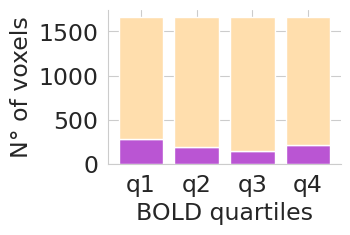

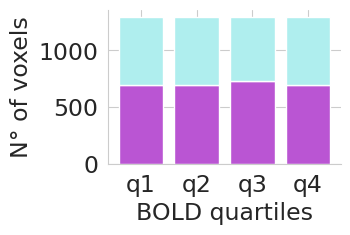

In [75]:
## add barplot: percentile BOLD false pos./neg##
################################################
perc25 = np.percentile(BOLD_percchange_median_pos, 25)
perc50 = np.percentile(BOLD_percchange_median_pos, 50)
perc75 = np.percentile(BOLD_percchange_median_pos, 75)


false_pos = BOLD_percchange_median_pos[CMRO2_percchange_median_pos<0]
correct_pos = BOLD_percchange_median_pos[CMRO2_percchange_median_pos>0]

BOLDpos = np.zeros((2,4))
BOLDpos[0,0] = len(correct_pos[correct_pos<perc25])
BOLDpos[0,1] = len(np.where(correct_pos[correct_pos<perc50]>perc25)[0])
BOLDpos[0,2] = len(np.where(correct_pos[correct_pos<perc75]>perc50)[0])
BOLDpos[0,3] = len(correct_pos[correct_pos>perc75])
BOLDpos[1,0] = len(false_pos[false_pos<perc25])
BOLDpos[1,1] = len(np.where(false_pos[false_pos<perc50]>perc25)[0])
BOLDpos[1,2] = len(np.where(false_pos[false_pos<perc75]>perc50)[0])
BOLDpos[1,3] =len(false_pos[false_pos>perc75])


fig, ax = plt.subplots(1, figsize=(3,2))
labels=('q1', 'q2', 'q3', 'q4')
#labels=('0 - '+str(round(perc25,2))+'%', str(round(perc25,2))+' - '+str(round(perc50,2))+'%', str(round(perc50,2))+' - '+str(round(perc75,2))+'%', str(round(perc75,2))+' - '+str(round(np.max(BOLD_percchange_median_pos),2))+'%')
#labels=('0-25%', '25-50%', '50-75%', '75-100%')
ax.bar(labels, BOLDpos[1,:], 0.8, label='false pos.', color='mediumorchid')
ax.bar(labels, BOLDpos[0,:], 0.8, bottom=BOLDpos[1,:],  label='correct pos.', color='navajowhite')
ax.set_ylabel('N° of voxels', fontsize=fontsize)
#plt.xticks(rotation=30, ha='right')
ax.set_xlabel('BOLD quartiles', fontsize=fontsize)
        
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)

for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)
            
#ax.legend()
plt.show()

fig.savefig(results_dir + '/Barplot25%bins_mask_'  + contrast + '_false_pos.png', dpi=300, bbox_inches='tight')


perc25 = np.percentile(BOLD_percchange_median_neg, 25)
perc50 = np.percentile(BOLD_percchange_median_neg, 50)
perc75 = np.percentile(BOLD_percchange_median_neg, 75)

false_neg = BOLD_percchange_median_neg[CMRO2_percchange_median_neg>0]
correct_neg = BOLD_percchange_median_neg[CMRO2_percchange_median_neg<0]


BOLDneg = np.zeros((2,4))
BOLDneg[0,0] = len(correct_neg[correct_neg>perc75])
BOLDneg[0,1] = len(np.where(correct_neg[correct_neg<perc75]>perc50)[0])
BOLDneg[0,2] = len(np.where(correct_neg[correct_neg<perc50]>perc25)[0])
BOLDneg[0,3] = len(correct_neg[correct_neg<perc25])
BOLDneg[1,0] = len(false_neg[false_neg>perc75])
BOLDneg[1,1] = len(np.where(false_neg[false_neg<perc75]>perc50)[0])
BOLDneg[1,2] = len(np.where(false_neg[false_neg<perc50]>perc25)[0])
BOLDneg[1,3] = len(false_neg[false_neg<perc25])



fig, ax = plt.subplots(1, figsize=(3,2))
labels=('q1', 'q2', 'q3', 'q4')
#labels=('0 - '+str(round(perc75,2))+'%', str(round(perc75,2))+' - '+str(round(perc50,2))+'%', str(round(perc50,2))+' - '+str(round(perc25,2))+'%', str(round(perc25,2))+' - '+str(round(np.min(BOLD_percchange_median_neg),2))+'%')
#labels=('0-25%', '25-50%', '50-75%', '75-100%')
ax.bar(labels, BOLDneg[1,:], 0.8,  label='false neg.', color='mediumorchid')
ax.bar(labels, BOLDneg[0,:], 0.8, bottom=BOLDneg[1,:], label='correct neg.', color='paleturquoise')
ax.set_xlabel('BOLD quartiles', fontsize=fontsize)
#ax.legend()
ax.set_ylabel('N° of voxels', fontsize=fontsize)
#plt.xticks(rotation=30, ha='right')
        
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)

for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)

plt.show()
fig.savefig(results_dir + '/Barplot25%bins_mask_'  + contrast + '_false_neg.png', dpi=300, bbox_inches='tight')


## brain plots: discordant and concordant voxels

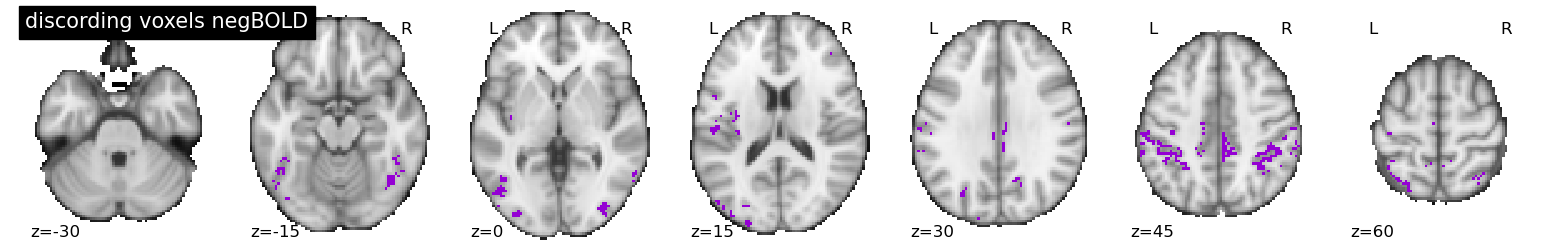

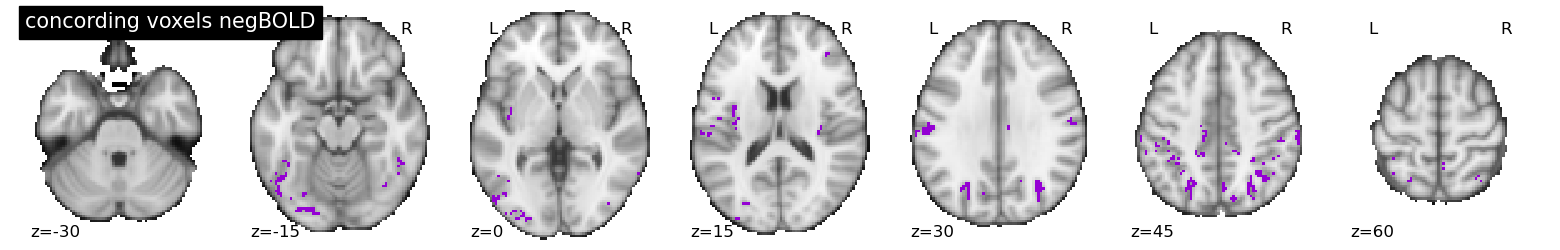

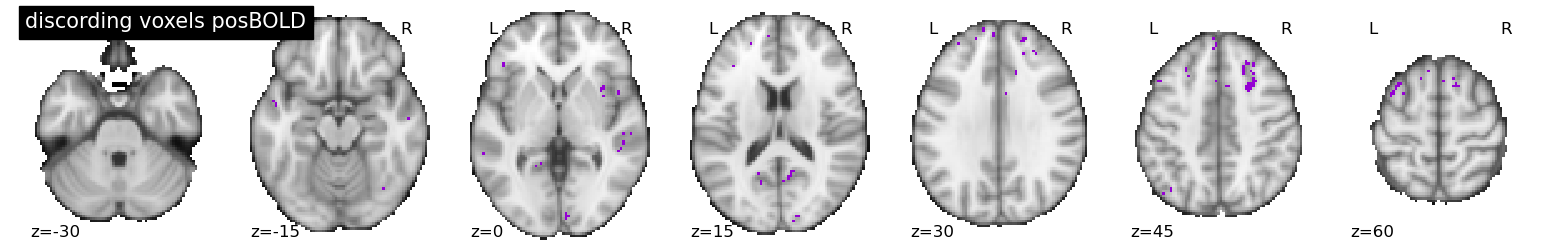

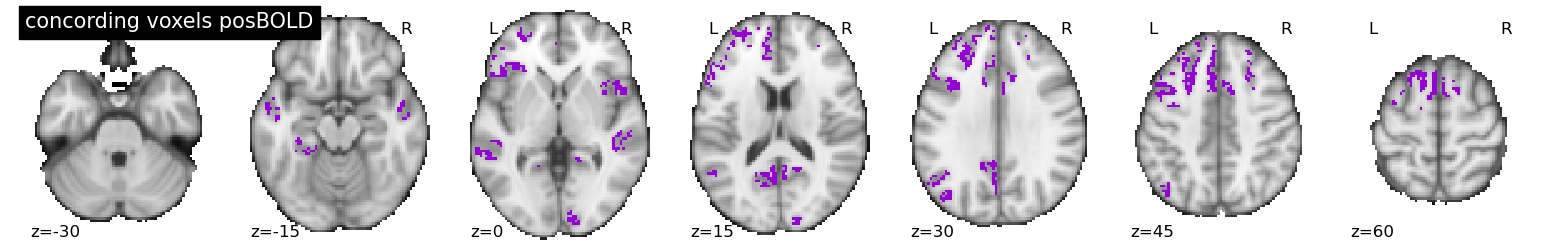

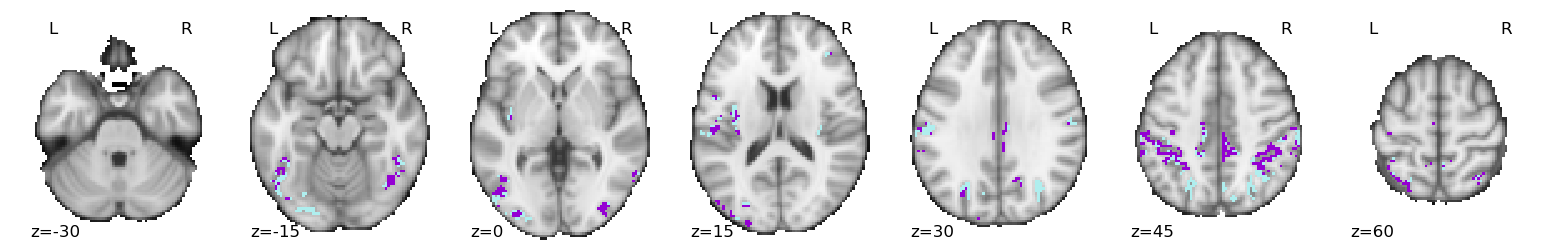

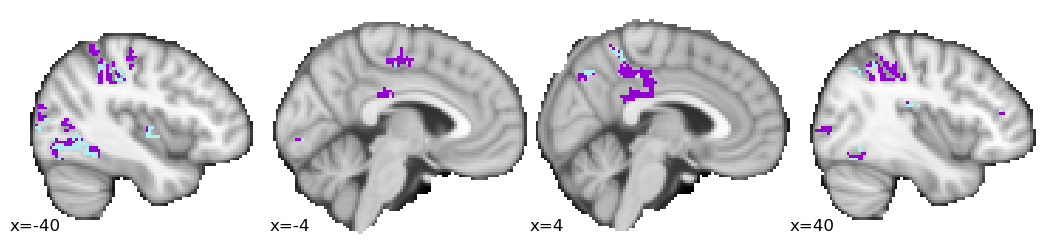

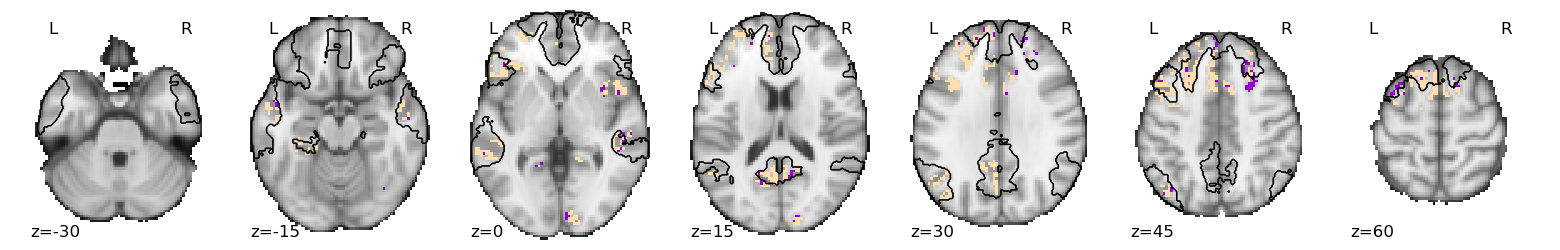

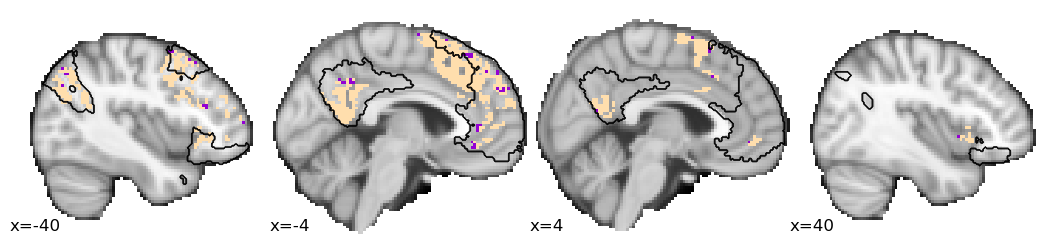

In [76]:
from matplotlib.colors import ListedColormap
DMN = os.path.join(derivatives_dir,'Yeo2011_7Networks_MNI152_FreeSurferConformed2mm_MNI_DMN.nii.gz')

cmap_neg = ListedColormap(["darkviolet", "paleturquoise" ])
cmap_pos = ListedColormap(["darkviolet", "navajowhite"])

neg_BOLD_idx = np.where(BOLD_percchange_median<0)
pos_BOLD_idx = np.where(BOLD_percchange_median>0)

neg_CMRO2_idx = np.where(CMRO2_percchange_median<0)
pos_CMRO2_idx = np.where(CMRO2_percchange_median>0)

neg_BOLD_pos_CMRO2 = np.intersect1d(neg_BOLD_idx[0], pos_CMRO2_idx[0])
neg_BOLD_neg_CMRO2 = np.intersect1d(neg_BOLD_idx[0], neg_CMRO2_idx[0])
pos_BOLD_neg_CMRO2 = np.intersect1d(pos_BOLD_idx[0], neg_CMRO2_idx[0])
pos_BOLD_pos_CMRO2 = np.intersect1d(pos_BOLD_idx[0], pos_CMRO2_idx[0])

##create niftis 
neg_BOLD_pos_CMRO2_nii = np.zeros(len(BOLD_percchange_median))
neg_BOLD_pos_CMRO2_nii[neg_BOLD_pos_CMRO2] = 1
neg_BOLD_pos_CMRO2_nifti = masker.inverse_transform(neg_BOLD_pos_CMRO2_nii)
nib.save(neg_BOLD_pos_CMRO2_nifti, os.path.join(results_dir, 'negBOLD_posCMRO2_' + contrast + '.nii.gz'))
disp=plotting.plot_img(neg_BOLD_pos_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_neg, 
                cut_coords = coords, vmin = 1, vmax = 5, title='discording voxels negBOLD')

neg_BOLD_neg_CMRO2_nii = np.zeros(len(BOLD_percchange_median))
neg_BOLD_neg_CMRO2_nii[neg_BOLD_neg_CMRO2] = 1
neg_BOLD_neg_CMRO2_nifti = masker.inverse_transform(neg_BOLD_neg_CMRO2_nii)
nib.save(neg_BOLD_neg_CMRO2_nifti, os.path.join(results_dir, 'negBOLD_negCMRO2_' + contrast + '.nii.gz'))
disp=plotting.plot_img(neg_BOLD_neg_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_neg, 
                cut_coords = coords, vmin = 1, vmax = 5, title='concording voxels negBOLD')

pos_BOLD_neg_CMRO2_nii = np.zeros(len(BOLD_percchange_median))
pos_BOLD_neg_CMRO2_nii[pos_BOLD_neg_CMRO2] = 1
pos_BOLD_neg_CMRO2_nifti = masker.inverse_transform(pos_BOLD_neg_CMRO2_nii)
nib.save(pos_BOLD_neg_CMRO2_nifti, os.path.join(results_dir,  'posBOLD_negCMRO2_' + contrast + '.nii.gz'))
disp=plotting.plot_img(pos_BOLD_neg_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_neg, 
                cut_coords = coords, vmin = 1, vmax = 5, title='discording voxels posBOLD')

pos_BOLD_pos_CMRO2_nii = np.zeros(len(BOLD_percchange_median))
pos_BOLD_pos_CMRO2_nii[pos_BOLD_pos_CMRO2] = 1
pos_BOLD_pos_CMRO2_nifti = masker.inverse_transform(pos_BOLD_pos_CMRO2_nii)
nib.save(pos_BOLD_pos_CMRO2_nifti, os.path.join(results_dir, 'posBOLD_posCMRO2_' + contrast + '.nii.gz'))
disp=plotting.plot_img(pos_BOLD_pos_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_neg, 
                cut_coords = coords, vmin = 1, vmax = 5, title='concording voxels posBOLD')

##create nifti :negative BOLD
neg_BOLD_pos_CMRO2_nii = np.zeros(len(BOLD_percchange_median))
neg_BOLD_pos_CMRO2_nii[neg_BOLD_pos_CMRO2] = 2
neg_BOLD_pos_CMRO2_nii[neg_BOLD_neg_CMRO2] = 4
neg_BOLD_pos_CMRO2_nifti = masker.inverse_transform(neg_BOLD_pos_CMRO2_nii)
disp=plotting.plot_img(neg_BOLD_pos_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_neg, 
                cut_coords = coords, vmin = 1, vmax = 5)
if task == 'calc':
    disp.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)
disp=plotting.plot_img(neg_BOLD_pos_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_neg, 
                cut_coords = coords, vmin = 1, vmax = 5,
                output_file=results_dir + '/CMRO2_deviation_negBOLD_' + contrast +  '.png')
disp=plotting.plot_img(neg_BOLD_pos_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='x', cmap=cmap_neg, 
                cut_coords = [-40,-4,4, 40], vmin = 1, vmax = 5)
if task == 'calc':
    disp.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)
disp=plotting.plot_img(neg_BOLD_pos_CMRO2_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='x', cmap=cmap_neg, 
                cut_coords = [-40,-4,4, 40], vmin = 1, vmax = 5,
                output_file=results_dir + '/CMRO2_deviation_negBOLD_' + contrast +  '_sag.png')



##create nifti :positive BOLD

pos_BOLD_neg_CMRO2_nii = np.zeros(len(BOLD_percchange_median))
pos_BOLD_neg_CMRO2_nii[pos_BOLD_neg_CMRO2] = 2
pos_BOLD_neg_CMRO2_nii[pos_BOLD_pos_CMRO2] = 4
pos_BOLD_neg_CMRO2_nii_nifti = masker.inverse_transform(pos_BOLD_neg_CMRO2_nii)

disp=plotting.plot_img(pos_BOLD_neg_CMRO2_nii_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_pos, 
                cut_coords = coords, vmin = 1, vmax = 5)
if task == 'mem':
    disp.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)
disp=plotting.plot_img(pos_BOLD_neg_CMRO2_nii_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=cmap_pos, 
                cut_coords = coords, vmin = 1, vmax = 5,
                output_file=results_dir + '/CMRO2_deviation_posBOLD_'+ contrast +  '.png')
disp=plotting.plot_img(pos_BOLD_neg_CMRO2_nii_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='x', cmap=cmap_pos, 
                cut_coords = [-40,-4,4, 40], vmin = 1, vmax = 5)
if task == 'mem':
    disp.add_contours(DMN,  colors='black', alpha = 1, linewidths=0.3)
disp=plotting.plot_img(pos_BOLD_neg_CMRO2_nii_nifti, bg_img=MNI_2mm_brain, threshold = 0, display_mode='x', cmap=cmap_pos, 
                cut_coords = [-40,-4,4, 40], vmin = 1, vmax = 5,
                output_file=results_dir + '/CMRO2_deviation_posBOLD_' + contrast +  '_sag.png')



## Barplots: discordant vs. concordant voxels

control
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
su

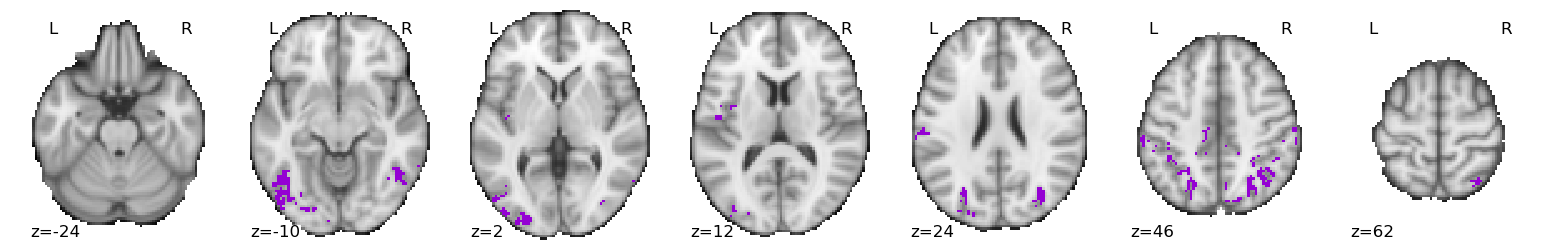

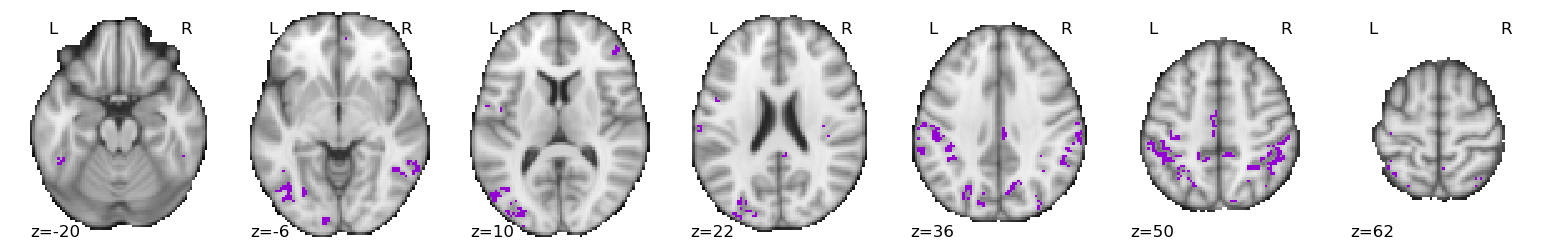

In [79]:
parameters = ['func', 'cmro2', 'cbf']

#######################################################
## run for either pos or neg masks, rerun for other ##
######################################################

BOLD_ROI = 'neg'
#BOLD_ROI = 'pos'


## store masks: areas with discordant (false) or concordant (true) voxels 

## negative ##
##############    
if BOLD_ROI == 'neg':
        colormap = ListedColormap(["darkviolet", "paleturquoise" ])

        ## divide into: real deactivation and dissociation areas!
        PLS_true_deact = os.path.join(results_dir,  'negBOLD_negCMRO2_' + contrast + '.nii.gz') #negBOLD_negCMRO2_memcontrol_CMRO2deact
        plotting.plot_img(PLS_true_deact, cmap=colormap,  bg_img=MNI_2mm_brain, threshold=0, display_mode='z')

        PLS_dissociation = os.path.join(results_dir, 'negBOLD_posCMRO2_' + contrast + '.nii.gz')
        plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_2mm_brain, threshold=0, display_mode='z')

        masks = [PLS_true_deact, PLS_dissociation]
        mask_names = ['BOLD true', 'BOLD false']

## positive ##
##############
if BOLD_ROI == 'pos':
        colormap = ListedColormap(["darkviolet", "navajowhite" ])

        ## divide into: real deactivation and dissociation areas!
        PLS_true_act =  os.path.join(results_dir, 'posBOLD_posCMRO2_' + contrast + '.nii.gz')

        plotting.plot_img(PLS_true_act, cmap=colormap,  bg_img=MNI_2mm_brain, threshold=0, display_mode='z')

        PLS_dissociation = os.path.join(results_dir,  'posBOLD_negCMRO2_' + contrast + '.nii.gz')
        plotting.plot_img(PLS_dissociation, cmap=colormap,  bg_img=MNI_2mm_brain, threshold=0, display_mode='z')

        ## positive masks
        masks = [PLS_true_act, PLS_dissociation]
        mask_names = ['BOLD true', 'BOLD false']

df_par_subj = pd.DataFrame()
df_par_vox_true= pd.DataFrame()
df_par_vox_diss= pd.DataFrame()
df_par_vox_PBR= pd.DataFrame()
df_par_vox_GM = pd.DataFrame()
for cond in conds:
    print(cond)
    for par in parameters: 
        for m, mask in enumerate(masks):
            masker = input_data.NiftiMasker(mask_img = mask) 
            mask_arr = np.array(nib.load(mask).dataobj)
            par_median=np.zeros(len(sids))
            par_median_vox = np.zeros((len(np.argwhere(mask_arr)), len(sids)))
            par_median_vox_GM = np.zeros((len(np.argwhere(YEO_SNR_mask_arr)), len(sids)))
            for i, ID in enumerate(sids): #loop over subjects
                sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
                print(sub)

                sub_dir = os.path.join(data_dir, sub)

                dir_anat = os.path.join(sub_dir, 'anat')
                dir_func = os.path.join(sub_dir, 'func')
                dir_perf = os.path.join(sub_dir, 'perf')

                dir_anat_deriv = os.path.join(derivatives_dir, sub, 'anat')
                dir_func_deriv = os.path.join(derivatives_dir, sub, 'func')
                dir_perf_deriv = os.path.join(derivatives_dir, sub, 'perf')
                dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')


                # load absolute values per condition to plot
                if par == 'func':
                    #load percent signal change image
                    #par_map = dir_func_deriv + '/' + sub + '_task-' + task + baseline + '_space-MNI152_BOLD_percchange.nii.gz'
                    par_map = dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_desc-fmriprep_BOLD_percchange.nii.gz'
                    #par_map = dir_func_deriv + '/' + sub + '_task-'+task + baseline+'_space-MNI152_BOLD_percchange_desc-preproc.nii.gz'
                if par != 'cmro2' and par !='func':
                    par_map = dir_qmri_deriv+ '/' + sub + '_task-'+cond +'_space-MNI152_'+ par + '.nii.gz'                
                if par == 'cmro2' and CMRO2_mode == 'orig':
                    if cond != 'calc' and cond != 'mem': ## during baseline: fully quant
                        par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + cond + '_space-MNI152_desc-orig_cmro2.nii.gz')
                    if cond == 'calc' or cond == 'mem': ## during task: semi-quant
                        par_map = os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant_cmro2.nii.gz')
                if par == 'cmro2' and CMRO2_mode == 'corrected':
                    if cond == 'calc': ## calc: semi-quant, CBV-corrected
                        par_map = os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant-corrected_cmro2.nii.gz')
                    if cond != 'calc' and cond != 'mem': ##baseline: fully quant
                        par_map = os.path.join(dir_qmri_deriv, sub + '_task-' + cond + '_space-MNI152_desc-orig_cmro2.nii.gz')
                    if cond == 'mem': ##semi-quant: task 
                        par_map = os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_base-'+baseline+'_space-MNI152_desc-semi-quant_cmro2.nii.gz')

                # mask with voxels that are within mask
                par_arr = np.squeeze(masker.fit_transform(par_map))   
                par_arr_GM = np.squeeze(masker_GM.fit_transform(par_map))   
                
                ## median per subject and mask
                par_median[i] = np.nanmedian(par_arr[par_arr!=0])
                
                ## all voxels within mask
                par_median_vox[:, i] = par_arr
                
                ## all voxels within GM
                par_median_vox_GM[:, i] = par_arr_GM

            
            ## put into dataframe
            df_par_subj[cond + mask_names[m]] = par_median
           
            ##median across subjects per voxel 
            par_median_voxel = np.nanmedian(par_median_vox, axis = 1)
            if cond == 'control' or cond == 'rest':
                df_par_vox_GM[par] = np.nanmedian(par_median_vox_GM, axis=1)

            
            if mask_names[m]=='BOLD true':
                if par =='func':
                    #if cond == 'calc':
                       # df_par_vox_true['calcrest ' + par + ' true'] = par_median_voxel  
                    if contrast == 'calccontrol':
                        df_par_vox_true['calccontrol ' + par + ' true'] = par_median_voxel 
                    if contrast == 'memcontrol':
                        df_par_vox_true['memcontrol ' + par + ' true'] = par_median_voxel 
                    if contrast == 'calcrest':
                        df_par_vox_true['calcrest ' + par + ' true'] = par_median_voxel 
                if par !='func':
                    df_par_vox_true[cond + ' ' + par + ' true'] = par_median_voxel  

            if mask_names[m]=='BOLD false':
                if par =='func':
                    #if cond == 'calc':
                        #df_par_vox_diss['calcrest ' + par + ' false'] = par_median_voxel  
                    if contrast == 'calccontrol':
                        df_par_vox_diss['calccontrol ' + par + ' false'] = par_median_voxel 
                    if contrast == 'memcontrol':
                        df_par_vox_diss['memcontrol ' + par + ' false'] = par_median_voxel 
                    if contrast == 'calcrest':
                        df_par_vox_diss['calcrest ' + par + ' false'] = par_median_voxel 
                if par !='func':
                    df_par_vox_diss[cond + ' ' + par + ' false'] = par_median_voxel             

            if mask_names[m]=='CALC-pos':
                if par =='func':
                    #if cond == 'calc':
                       # df_par_vox_PBR['calcrest ' + par + ' CALC-pos'] = par_median_voxel  
                    if contrast == 'calccontrol':
                        df_par_vox_PBR['calccontrol ' + par + ' CALC-pos'] = par_median_voxel 
                    if contrast == 'memcontrol':
                        df_par_vox_PBR['memcontrol ' + par + ' CALC-pos'] = par_median_voxel 
                    if contrast == 'calcrest':
                        df_par_vox_PBR['calcrest ' + par + ' CALC-pos'] = par_median_voxel 
                if par !='func':
                    df_par_vox_PBR[cond + ' ' + par + ' CALC-pos'] = par_median_voxel 

median CMRO2 change: -1.6426330430356666
median CBF change: -2.543521808545073


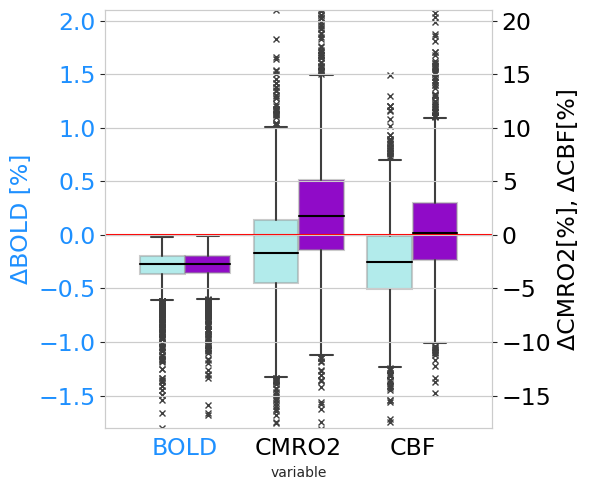

In [80]:
## plot all %change values in one plot ##
############################################
if BOLD_ROI == 'neg':
    colormap = (["paleturquoise", "darkviolet" ])
if BOLD_ROI == 'pos':
    colormap = (["navajowhite", "darkviolet" ])

        
df_percchange = pd.DataFrame()
for par in parameters:

    if contrast=='calccontrol':
        if par !='func':
            ## percent
            diff_calc_control_true = (df_par_vox_true['calc ' + par + ' true'] - df_par_vox_true['control ' + par + ' true']) / df_par_vox_true['control ' + par + ' true'] * 10
            diff_calc_control_false = (df_par_vox_diss['calc ' + par + ' false'] - df_par_vox_diss['control ' + par + ' false']) / df_par_vox_diss['control ' + par + ' false'] * 10
            ## print CBF and CMRO2 chane + n-factor
            if par == 'cbf':
                median_CBF_change = np.nanmedian(diff_calc_control_true )
                print('median CBF change: ' + str(median_CBF_change*10))
            if par == 'cmro2':
                median_CMRO2_change = np.nanmedian(diff_calc_control_true )
                print('median CMRO2 change: ' + str(median_CMRO2_change*10))                
        if par =='func':
            diff_calc_control_true = df_par_vox_true['calccontrol ' + par + ' true']
            diff_calc_control_false= df_par_vox_diss['calccontrol ' + par + ' false']
    if contrast=='memcontrol':
        if par !='func':
            ## percent
            diff_calc_control_true = (df_par_vox_true['mem ' + par + ' true'] - df_par_vox_true['control ' + par + ' true']) / df_par_vox_true['control ' + par + ' true'] * 10
            diff_calc_control_false = (df_par_vox_diss['mem ' + par + ' false'] - df_par_vox_diss['control ' + par + ' false']) / df_par_vox_diss['control ' + par + ' false'] * 10
            if par == 'cbf':
                median_CBF_change = np.nanmedian(diff_calc_control_true )
                print('median CBF change: ' + str(median_CBF_change*10))
            if par == 'cmro2':
                median_CMRO2_change = np.nanmedian(diff_calc_control_true )
                print('median CMRO2 change: ' + str(median_CMRO2_change*10))
        if par =='func':
            diff_calc_control_true = df_par_vox_true['memcontrol ' + par + ' true']
            diff_calc_control_false= df_par_vox_diss['memcontrol ' + par + ' false']
    if contrast=='calcrest':
        if par !='func':
            ## percent
            diff_calc_control_true = (df_par_vox_true['calc ' + par + ' true'] - df_par_vox_true['rest ' + par + ' true']) / df_par_vox_true['rest ' + par + ' true'] * 10
            diff_calc_control_false = (df_par_vox_diss['calc ' + par + ' false'] - df_par_vox_diss['rest ' + par + ' false']) / df_par_vox_diss['rest ' + par + ' false'] * 10
            #diff_calc_control_PBR = (df_par_vox_PBR['calc ' + par + ' CALC-pos'] - df_par_vox_PBR['control ' + par + ' CALC-pos']) / df_par_vox_PBR['control ' + par + ' CALC-pos'] * 100
            if par == 'cbf':
                median_CBF_change = np.nanmedian(diff_calc_control_true )
                print('median CBF change: ' + str(median_CBF_change*10))
            if par == 'cmro2':
                median_CMRO2_change = np.nanmedian(diff_calc_control_true )
                print('median CMRO2 change: ' + str(median_CMRO2_change*10))
        if par =='func':
            diff_calc_control_true = df_par_vox_true['calcrest ' + par + ' true']
            diff_calc_control_false= df_par_vox_diss['calcrest ' + par + ' false']
            
    df_percchange[par] = np.concatenate((diff_calc_control_true, diff_calc_control_false), axis=0)
    df_percchange['ROI'] = np.concatenate((len(diff_calc_control_true)*['concordant'], len(diff_calc_control_false)*['discordant']), axis=0)
    
df_percchange_melted = pd.melt(df_percchange, id_vars='ROI')
if len(parameters)==3:
    fig, ax = plt.subplots(1, figsize= (6,5))
if len(parameters)==4:
    fig, ax = plt.subplots(1, figsize= (7,5.5))

sns.boxplot(x='variable', y='value', hue='ROI', data=df_percchange_melted, ax=ax, palette=colormap, saturation=0.9,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
        
#bar = sns.barplot(x='variable', y='value', hue='ROI', data=df_percchange_melted, ax=ax, palette=colormap,  
#           estimator=np.median, ci=95, capsize=.05, n_boot=2000, errwidth=1, saturation=0.9, alpha=0.8) 
#bar = sns.barplot(x='variable', y='value', hue='ROI', data=df_percchange_melted, ax=ax, palette=colormap,  
#           estimator=np.median, ci=95, capsize=.05, n_boot=2000, errwidth=1, saturation=0.9, alpha=0.8) 

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)
    #ax.set_title('coupling CBF/BOLD, CMRO2/BOLD')
if BOLD_ROI == 'neg':
    color = 'dodgerblue'
if BOLD_ROI == 'pos':
    if task[0] != 'mem':
        color = 'darkorange'
    if task[0] == 'mem':
        color = 'darkorange'
ax.set_ylim(-1.8, 2.1)
ax.set_yticks([-1.5, -1,  -0.5, 0,  0.5,  1, 1.5, 2])
if baseline == 'rest':
    ax.set_ylim(-2, 3)
    ax.set_yticks([-1, -0.5, 0,  0.5, 1.5,  2])
#ax.set_ylim(-0.2, 1.25)
#ax.set_yticks([0, 0.25, 0.5, 0.75, 1, 1.25])
## set line at y=0
ax.hlines(0, -0.7, 2.7, colors='red', linestyles='solid')
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylabel('ΔBOLD [%]', fontsize = fontsize, color=color)  # we already handled the x-label with ax1
if len(parameters)==4:
    ax.set_xticklabels(['BOLD', 'CMRO2', 'CBF', 'OEF'])  # we already handled the x-label with ax1
if len(parameters)==3:
    ax.set_xticklabels(['BOLD', 'CMRO2', 'CBF'])  # we already handled the x-label with ax1
[t.set_color(i) for (i,t) in zip([color,'black','black'],ax.xaxis.get_ticklabels())]
#ax.legend(fontsize=fontsize-5,loc="upper left")
ax.legend_.remove()

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
#ax2.plotsns.barplot(x="ROI", y="percchange", hue="parameter", data=df_percchange_median, estimator=np.median, ci=95, capsize=.05, n_boot=2000, errwidth=1,
#                 saturation=0.9, alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-18, 21)
ax2.set_yticks([-15, -10, -5, 0, 5, 10, 15, 20])
if baseline == 'rest':
    ax2.set_ylim(-20, 30)
    ax2.set_yticks([-20, -15, -10, -5, 0,  5, 10, 15, 20, 25, 30])

#ax2.set_ylim(-2, 12.5)
#ax2.set_yticks([0, 2.5, 5, 7.5, 10, 12.5])

if len(parameters)==4:
    ax2.set_ylabel('ΔCMRO2[%], ΔCBF[%], ΔOEF[%]', color=color, fontsize = fontsize)  # we already handled the x-label with ax1
if len(parameters)==3:
    ax2.set_ylabel('ΔCMRO2[%], ΔCBF[%]', color=color, fontsize = fontsize)  # we already handled the x-label with ax1

#set x-tick and y-ticke label size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(fontsize)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

if len(parameters)==4:
    fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_inline_oppos_BOLD_CMRO2_CBF_OEF.png', dpi=300, bbox_inches='tight')
if len(parameters)==3:
    fig.savefig(results_dir + '/N' + N_subj + '_BOLD' + BOLD_ROI + '_' + par + '_inline_oppos_BOLD_CMRO2_CBF.png', dpi=300, bbox_inches='tight')